# [Weather data and solar radiation](../t01/t01ReadWeatherData.ipynb)

# [Simple wall](../t02/t02SimpleWall.ipynb)

# State-space representation from thermal circuit

Objectives
- Physical analysis of a cubic building with 5 identical walls & a transparent wall, air infiltration, and HVAC system.
- Thermal circuit modelling the building.
- Mathematical model as a system of Differential Algebraic Equations (DAE) and state-space representation.
- Steady-state and dynamic simulation.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dm4bem

## Physical analysis and mathematical modelling

### Description of the building

![cube](./figures/t03_cube_principle.png)
> Figure 1. Simple ventilated room (5 walls and 1 window) equiped with an HVAC system which acts as a proportional controller.

Let’s consider a cubic building with an HVAC systems controlled by a [proportional controller](https://en.m.wikipedia.org/wiki/Proportional_control).

The dimensions and surface areas of the building are:
- $l=3 \: \mathrm{m}$ - length of the cube;
- $S_g=l^2$   - surface of the glass wall;
- $S_c = S_i = 5 \times S_g$   - surface of the 5 concrete and insulation walls.

In [2]:
l = 3               # m length of the cubic room
Sg = l**2           # m² surface of the glass wall
Sc = Si = 5 * Sg    # m² surface of concrete & insulation of the 5 walls

### Thermo-physical properties
The thermophysical properties of the air:

In [3]:
air = {'Density': 1.2,                      # kg/m³
       'Specific heat': 1000}               # J/kg.K
pd.DataFrame.from_dict(air, orient='index', columns=['air'])

,air
Density,1.2
Specific heat,1000.0


The [thermophysical properties](https://energieplus-lesite.be/donnees/enveloppe44/enveloppe2/conductivite-thermique-des-materiaux/) and the surface areas of the three materials (i.e., concrete, insulation, glass):

In [4]:
wall = {'Conductivity': [1.4, 0.027, 1.4],  # W/m.K
        'Density': [2300, 55, 2500],        # kg/m³
        'Specific heat': [880, 1210, 750],  # J/kg.K
        'Width': [0.2, 0.08, 0.004],
        'Surface': [5 * l**2, 5 * l**2, l**2],  # m²
        'Slices': [4, 2, 1]}                # number of  slices
wall = pd.DataFrame(wall, index=['Concrete', 'Insulation', 'Glass'])
wall

,Conductivity,Density,Specific heat,Width,Surface,Slices
Concrete,1.400,2300,880,0.200,45,4
Insulation,0.027,55,1210,0.080,45,2
Glass,1.400,2500,750,0.004,9,1


where `Slices` is the number of meshes used in discretization. 

The [radiative properties](https://en.wikipedia.org/wiki/Emissivity#Absorptivity) of the surfaces:
- long wave [emmisivity](https://www.engineeringtoolbox.com/emissivity-coefficients-d_447.html) of concrete (betwen normal and rough) and glass pyrex;
- short wave [absortivity of solar radiation](https://www.engineeringtoolbox.com/solar-radiation-absorbed-materials-d_1568.html) by white smooth surfaces;
- short wave [transmittance](https://www.engineeringtoolbox.com/optical-properties-glazing-materials-d_1355.html) of window glass (thickness of 4 mm);
- short wave [absortivity and transmittance](https://energieplus-lesite.be/techniques/enveloppe7/composants-de-l-enveloppe/vitrages/vitrage-permettant-le-controle-solaire/) of reflective blue window glass.

In [5]:
ε_wLW = 0.85    # long wave emmisivity wall concrete
ε_gLW = 0.90    # long wave emmisivity glass pyrex
α_wSW = 0.25    # short wave absortivity white smooth surface
α_gSW = 0.38    # short wave absortivity reflective blue glass
τ_gSW = 0.30    # short wave transmitance reflective blue glass

The [Stefan-Boltzmann constant](https://en.m.wikipedia.org/wiki/Stefan–Boltzmann_constant) is:

In [6]:
σ = 5.67e-8     # W/m²⋅K⁴ Stefan-Bolzmann constant
σ

5.67e-08

The [view factor](https://en.m.wikipedia.org/wiki/View_factor) between the wall and the window (glass) is 1/5.

In [7]:
Fwg = 1 / 5     # view factor wall - glass


Conventional values for the [convection coeficients](https://energieplus-lesite.be/theories/enveloppe9/echanges-chaleur-parois/resistance-thermique-d-echange-superficiel/) are 8 W/(m² K) for indoor and 25 W/(m² K) for outdoor convection.

In [8]:
h = pd.DataFrame([{'in': 8., 'out': 25}], index=['h'])  # W/m²⋅K
h

,in,out
h,8.0,25


## Thermal circuit

Heat transfert is:
- through the walls (concrete and insulation), 
- through the window,
- by ventilation,
- from the HVAC system.

The HVAC system is modelled as a proportional controller. There is long wave radiative exchange between the wall and the glass. Sources are:
- temperature sources:
    - outdoor atmospheric air;
    - indoor set point;
- flow rate sources:
    - solar radiation on the outdoor and the indoor walls;
    - auxiliary heat gains in the thermal zone.

![heat_processes](./figures/t03_heat_process.png)
> Figure 2. Heat processes for the cubic building shown in Figure 1.

![thermal_circuit](./figures/t03_therm_circ.png)
> Figure 3. Thermal circuit for the cubic building shown in Figure 1 and the heat processes shown in Figure 2.

Figure 3 shows the models of:
- concrete & insulation wall: in red;
- wall glass: in green;
- ventilation: in magenta;
- indoor volume: in blue (conductances 6 & 7 for covection; conductance 5 for long wave radiation between the walls and the glass);
- HVAC system: in black.

The sources are:
- $T_o$ - outdoor temperature, °C;
- $T_{i,sp}$ - set-point temperaure for the indoor air, °C;
- $\Phi_o$ - solar radiation absorbed by the outdoor surface of the wall, W;
- $\Phi_i$ - solar radiation absorbed by the indoor surface of the wall, W;
- $\Phi_a$ - solar radation absorbed by the glass, W;
- $\dot{Q}_a$ - auxiliary heat gains (i.e., occupants, electrical devices, etc.), W.

*Note*: The known values, i.e. the elements of the circuit (the conductances $G$ and capacities $C$) and the sources (of temperature $T$ and of flow rate $\Phi$ or $\dot{Q}$) are noted in uppercase (capital letters). The unknows variables, i.e. the temperatures in the nodes $\theta$ and the flow rates on the branches $q$, are in lowercase letters.

### Thermal coductances
#### Conduction
The resistances 1, 2, 3, and 4 of the thermal circuit from Figure 3 model the heat transfer by conduction. The thermal conductances for conduction are of the form:
$$G_{cd} = \frac{\lambda}{w}S$$
where:

- $\lambda$ - [thermal conductvity](https://en.m.wikipedia.org/wiki/Thermal_conductivity), W/(m⋅K);
- $w$ - width of the material, m;
- $S$ - surface area of the wall, m².

In [9]:
# Conduction
G_cd = wall['Conductivity'] / wall['Width'] * wall['Surface']
pd.DataFrame(G_cd, columns={'Conductance W/K'})

,Conductance W/K
Concrete,315.0000
Insulation,15.1875
Glass,3150.0000


#### Convection
The resistances 0, 6 and 7 are thermal resistances for convection of the form:
$$G_{cv} = {h S}$$
where:
- $h$ is the [convection coefficient](https://en.m.wikipedia.org/wiki/Heat_transfer_coefficient), W/(m²⋅K);
- $S$ - surface area of the wall, m². 

In [10]:
# Convection
Gw = h * wall['Surface'][0]     # wall
Gg = h * wall['Surface'][2]     # glass

#### Long wave radiation

The long-wave heat exchange between surfaces may be modelled by using the concept of [radiosity](https://en.m.wikipedia.org/wiki/Radiosity_(radiometry). 

![LW_rad_excg](./figures/t03_LW_rad_excg.png)
> Figure 4. Radiative long-wave heat exchange between two surfaces: a) modeled by emmitance (source) and radiosity (nodes); b) modeled by linearization of emmitance (temperature sources) and radiosity (temperature nodes).

For two surfaces, shown by temperature nodes 4 and 5 in Figure 3 and by nodes 1 and 2 in Figure 4, the [conductances](https://en.m.wikipedia.org/wiki/Radiosity_(radiometry)#Circuit_analogy) for radiative heat exchange expressed by using the emmitance (or the [radiant excitance](https://en.m.wikipedia.org/wiki/Radiant_exitance))  of the black body, [radiosity](https://en.m.wikipedia.org/wiki/Radiosity_(radiometry)), and [reciprocity](https://en.m.wikipedia.org/wiki/View_factor#Reciprocity) of view factors  are:

$$G_{1}^{r} = \frac{\varepsilon_1}{1 - \varepsilon_1} S_1$$

$$G_{1,2}^{r} = F_{1,2} S_1 = F_{2,1} S_2$$

$$G_{2}^{r} = \frac{\varepsilon_2}{1 - \varepsilon_2} S_2$$

The net flows leaving the surfaces 1 and 2 are:

$$q_{net,1} = \frac{\varepsilon_1}{1 - \varepsilon_1} S_1 (M_1^o - J_1)= G_1^r (M_1^o - J_1)$$

$$q_{net,2} = \frac{\varepsilon_2}{1 - \varepsilon_2} S_2 (M_2^o - J_2)= G_2^r (M_2^o - J_2)$$

respectively. The net flow between surfaces 1 and 2 is:

$$q_{1,2} = F_{1,2} S_1 (J_1 - J_2) = F_{2,1} S_2 (J_1 - J_2)= G_{1,2}^r (J_1 - J_2)$$

In order to express the long-wave radiative exchange as a function of differences of temperature, a linearization of the difference of temperatures $T_1^4 - T_2^4$ may be used:

$$T_1^4 - T_2^4 = (T_1^2 + T_2^2)(T_1 + T_2)(T_1 - T_2) = 4 \bar{T}^3 (T_1 - T_2)$$

where the mean temperature $\bar{T}$, measurd in kelvin, is:

$$\bar{T} =\sqrt[3]{ \frac{(T_1^2 + T_2^2)(T_1 + T_2)}{4}}$$

The evaluation of mean temperaure, $\bar{T}$, needs the values of the surface tempetratures, $T_1$ and $T_2$. An initial guess can be used (and then an iterative process, for a more precise evaluation).

After linearization, the conductances for radiative heat exchange are:

$$G_{1} = 4 \sigma \bar{T}^3 \frac{\varepsilon_1}{1 - \varepsilon_1} S_1$$

$$G_{1,2} = 4 \sigma \bar{T}^3 F_{1,2} S_1 = 4 \sigma \bar{T}^3 F_{2,1} S_2$$

$$G_{2} = 4 \sigma \bar{T}^3 \frac{\varepsilon_2}{1 - \varepsilon_2} S_2$$

In [11]:
Tm = 20 + 273   # K, mean temp for radiative exchange

GLW1 = 4 * σ * Tm**3 * ε_wLW / (1 - ε_wLW) * wall['Surface']['Insulation']
GLW12 = 4 * σ * Tm**3 * Fwg * wall['Surface']['Insulation']
GLW2 = 4 * σ * Tm**3 * ε_gLW / (1 - ε_gLW) * wall['Surface']['Glass']

The equivalent conductance for the radiative long-wave heat exchange between the wall and the glass is:
$$G = \frac{1}{1/G_1 + 1/G_{1,2} + 1/G_2}$$

In [12]:
GLW = 1 / (1 / GLW1 + 1 / GLW12 + 1 / GLW2)

*Note*: Resistances in [series or parallel](https://en.m.wikipedia.org/wiki/Series_and_parallel_circuits) can be replaced by their equivalent resistance. 

#### Advection

Let's consider that the air infiltration is given in [air changes per hour (ACH)](https://en.m.wikipedia.org/wiki/Air_changes_per_hour). The volumetric air flow rate, in m³/s, is:

$$\dot{V}_a = \frac{\mathrm{ACH}}{3600} V_a$$

In [13]:
Va = l**3                   # m³ volume of air
ACH = 1                     # air changes per hour
Va_dot = ACH / 3600 * Va    # m³/s air infiltration

The net flow rate that the building receives by ventilation, i.e., by introducing outdoor air at temperature $T_o$ and extracting indoor air at temperature $\theta_i$ is:

$$q_v = \dot{m}_a c_a (T_o - \theta_i) = \rho_a c_a \dot{V}_a (T_o - \theta_i)$$.

Thefore, the conductance of advection by ventilation is:

$$G_v = \rho_a c_a \dot{V}_a$$

In [14]:
# ventilation & advection
Gv = air['Density'] * air['Specific heat'] * Va_dot

#### Proportional controller

In the simplest representation, the [HVAC system](https://en.m.wikipedia.org/wiki/HVAC_control_system) can be considered as a [proportional controller](https://en.m.wikipedia.org/wiki/Proportional_control). The flow injected by the [HVAC](https://en.m.wikipedia.org/wiki/Heating,_ventilation,_and_air_conditioning) system into the controlled space is:

$$ q_{HVAC} = K_p (T_{i, sp} - \theta_i)$$

This equation shows that the proportional controller, modelling the HVAC system that adjusts the flow $q_{HVAC}$ in order to control the indoor temeprature $\theta_i$ at the set-point value $T_{i,sp}$, can be modelled as a source of temperature, $T_{i, sp}$, and a conductance, $K_p$:
- If the controller gain tends to infinity, $K_p \rightarrow \infty$, then the control is perfect, $\theta_i \rightarrow T_{i, sp}$.
- If the controller gain tends to zeo, $K_p \rightarrow 0$, then the controller is not acting and the building is in free-running ([Ghiaus 2003](https://doi.org/10.1016/S0378-7788(02)00110-X)).

*Note*: Respecting the [sign convention](https://en.m.wikipedia.org/wiki/Passive_sign_convention#Active_and_passive_components), the flow rate $q_{HVAC}$ is oriented from $T_{i,sp}$ towards node $\theta_i$.

In [15]:
# P-controler gain
Kp = 1e4            # almost perfect controller Kp -> ∞
Kp = 1e-3           # no controller Kp -> 0
Kp = 0

#### Conductaneces in series and/or parallel
If two resistances are connected to a temeprature node which has no capacity and/or flow rate source, then the resistances can be considered in [series or paralle](https://en.m.wikipedia.org/wiki/Series_and_parallel_circuits) (depending on the conection). For example, for the outdoor side of the glass, the outdoor convection resistance and the conduction resistance coressponding to half of the width of the glass is:

$$ G_{gs} = \frac{1}{1/G_{g,cv.out } + 1/(2 G_{g,cd})} =  
\frac{1}{\frac{1}{h_{out} S_g} + \frac{w / 2}{\lambda S_g}}
$$


In [16]:
# glass: convection outdoor & conduction
Ggs = float(1 / (1 / Gg['out'] + 1 / (2 * G_cd['Glass'])))

### Thermal capacities
#### Walls
The thermal capacities of the wall are of the form:
$$C_w= m_w c_w= \rho_w c_w w_w S_w$$
where:
- $C_w$ is the [thermal capacity](https://en.m.wikipedia.org/wiki/Heat_capacity) of the wall, J/kg;
- $m_w = \rho_w w_w S_w$ - mass of the wall, kg;
- $c_w$ - [specific heat capacity](https://en.m.wikipedia.org/wiki/Specific_heat_capacity), J/(kg⋅K);
- $\rho_w$ - [density](https://en.m.wikipedia.org/wiki/Density), kg/m³;
- $w_w$ - width of the wall, m;
- $S_w$ - surface area of the wall, m².

In [17]:
C = wall['Density'] * wall['Specific heat'] * wall['Surface'] * wall['Width']

#### Air
Similarly, the thermal capacity of the air is:
$$C_a = m_a c_a = \rho_a c_a V_a$$

where:
- $C_a$ is the thermal capacity of the air, J/kg;
- $m_a = \rho_a V_a$ - mass of the air, kg;
- $c_a$ - specific heat capacity of the air, J/(kg⋅K).

In [18]:
C['Air'] = air['Density'] * air['Specific heat'] * Va
pd.DataFrame(C, columns={'Capacity J/kg'})

,Capacity J/kg
Concrete,18216000.0
Insulation,239580.0
Glass,67500.0
Air,32400.0


### Temperature sources

The temperaure sources model temperatures which vary idependently of what happens in the themal circuit. Generally, the temperature sources are:
- outdoor air and ground temperature;
- adjacent spaces with controlled temperature;
- set-point temperatures.

#### Outdoor air and ground temperature
The hourly values of outdoor temperatures can be obtained from weather data files from the [Repository of free climate data for building performance simulation](http://climate.onebuilding.org) or from [Weather data for EnergyPlus](https://energyplus.net/weather).

#### Adjacent spaces with controlled temperature

If the adjacent spaces are controlled by a HVAC system, it means that their temperaure can be considered independent of the studied thermal zone(s); therefore, they can be modelled by a temperature source.

#### Set-point temperature

Set-point temperatures do not depend on the heat transfer processes of the analyzed thermal zone(s). If the HVAC system can deliver the heat flow rate:

$$ q_{HVAC} = K_p (T_{i, sp} - \theta_i)$$

then the set-point for indoor temperature, $T_{i, sp}$, may be modelled by a source of temperature.

### Heat flow rate sources

#### Solar radiation absorbed by the walls

The direct, diffuse and reflected components of the solar radiation on a tilted surface can be estimated from weather data by using the funcion `sol_rad_tilt_surf` from the module `dm4bem`.

##### External wall

The radiation absorbed by the outdoor surface of the wall is:

$$\Phi_o = \alpha_{w,SW} S_w \Phi_{tot}$$

where:
- $\alpha_{w,SW}$ is the absortion coefficient of the outdoor surface of the wall in showrt wave, $0 \leqslant \alpha_{w,SW} \leqslant 1$;
- $S_w$ - surface area of the wall, m²;
- $\Phi_{tot}$ - intensity of total solar radiation on the wall, W/m².



##### Internal walls

The total shortwave incident irradiation on the wall $i$, $G_i$, may be estimated as a function of the direct solar irradiation incident on the surface of the walls, $G_{i}^{o}$:

$$S_i G_i = S_i G_{i}^{o} + \sum_{j=1}^{n} F_{j,i} S_j \rho_j G_j$$

where:
- $S_i$ is the area of the surface of the wall $i$, m²;
- $G_i$ - total irradiation received directly and by mutiple reflections on surface $i$, W/m²;
- $G_{i}^{o}$ - irradiance received directly from the sun on surface $i$, W/m²;
- $F_{j, i}$ - view factor between surface $j$ and surface $i$, $0 ⩽ F_{j,i} ⩽ 1$;
- $\rho_j$ - reflectivity of surface $j$, $0 ⩽ \rho_j ⩽ 1$.


By taking into account the [reciprocity](https://en.m.wikipedia.org/wiki/View_factor#Reciprocity) of the view factors: $S_i F_{i,j} = S_j F_{j,i}$, the previous equation becomes:

$$
\begin{bmatrix}
1 - \rho_1 F_{1,1} & - \rho_2 F_{1,2}     & ...  & - \rho_n F_{1,n}\\ 
- \rho_1 F_{2,1}   & 1 - \rho_2 F_{2,2}  & ...  & - \rho_n F_{2,n} \\ 
...                         & ...                            & ...  & ... \\ 
- \rho_1 F_{n,1}  & - \rho_2 F_{n,1}      & ... & 1 - \rho_n F_{n,n}
\end{bmatrix} \begin{bmatrix}
G_1\\ 
G_2\\ 
...\\ 
G_n
\end{bmatrix} = \begin{bmatrix}
G_{1}^{o}\\ 
G_{2}^{o}\\ 
...\\ 
G_{n}^{o}
\end{bmatrix}
$$

or

$$[I - \rho F] G = G^o$$

where:

- $I =\begin{bmatrix}
1 & 0 & ... & 0 \\ 
0 & 1 & ... & 0 \\ 
... & ... & ... & ...\\ 
0 & 0 & ... & 1 
\end{bmatrix}, $ is the identity matrix;

- $\rho = \begin{bmatrix}
\rho_1 & 0 & ... & 0\\ 
0 & \rho_2  & ... & 0 \\ 
... & ... & ... & ...\\ 
0 & 0 & ... & \rho_n 
\end{bmatrix}$ - matrix of reflexivities;

- $F = \begin{bmatrix}
F_{1,1} & F_{1,2} & ... & F_{1,n}\\ 
F_{2,1} & F_{2,2} & ... & F_{2,n} \\ 
... & ... & ... & ...\\ 
F_{n,1} & F_{n,2} & ... & F_{n,n}
\end{bmatrix}$ - matrix of view factors;

- $G = \begin{bmatrix}
G_1\\ 
G_2\\ 
...\\ 
G_n
\end{bmatrix}$ - vector of unknown total irradiances;

- $G^o = \begin{bmatrix}
G_{1}^{o}\\ 
G_{2}^{o}\\ 
...\\ 
G_{n}^{o}
\end{bmatrix}$ - vector of direct solar irradiances.

The unknown total irradiances are then
$$ G = [I - \rho F]^{-1} G^o$$

The radiative short wave (i.e. solar) heat flow rate on each surface is:
$$ \Phi = S G $$
where:
- $\Phi = \begin{bmatrix}
\Phi_1\\ 
\Phi_2\\ 
...\\ 
\Phi_n
\end{bmatrix}$ - vector of total heat flow rates due to solar radiation, W; 

- $S =\begin{bmatrix}
S_1 & 0 & ... & 0 \\ 
0 & S_2 & ... & 0 \\ 
... & ... & ... & ...\\ 
0 & 0 & ... & S_n 
\end{bmatrix}$ - matrix of surface areas of walls $i$, m².

#### Internal sources

Internal flow rates are generated by occupants and by the electrical equipment (with values given for [offices](https://energieplus-lesite.be/theories/bilan-thermique44/charges-thermiques-internes-pour-les-bureaux/), [commercial spaces](https://energieplus-lesite.be/theories/bilan-thermique44/charges-thermiques-internes-pour-les-commerces/))

## System of Algebraic-Differential Equation (DAE)

The analysis of a thermal circuit (or the direct problem ([Ghiaus 2022](https://hal.archives-ouvertes.fr/hal-03484064/document)) means to find the temperatures in the nodes, $\theta$, and the heat flows on the branches, $q$, i.e. to solve the system of [Differential-Algebraic Equations (DAE)](https://en.m.wikipedia.org/wiki/Differential-algebraic_system_of_equations) (Figures 3 and 4):

$$\left\{\begin{array}{ll}
C \dot{\theta} = -(A^T G A) \theta + A^T G b + f\\ 
q = G (-A \theta + b)
\end{array}\right.$$

where:
- $\theta$ temperature vector of size $n_\theta$ equal to the number of nodes;
- $q$ heat flow vector of size $n_q$ equal to the numer of branches;
- $A$ [incidence matrix](https://en.m.wikipedia.org/wiki/Incidence_matrix) of size $n_q$ rows and $n_{\theta}$ columns, where $n_q$ is the number of flow branches and $n_{\theta}$  is the number of temperature nodes: shows how the temperature nodes are conected by branches of heat flow:
    - if flow *m* enters into the node *n*, then the element (*m, n*) of the matix A is 1, i.e., $A_{m,n} = 1$;
    - if flow *m* exits from the node *n*, then the element (*m, n*) is -1, i.e., $A_{m,n} = -1$, ; 
    - if flow *m* is not connected to node *n*, then the element (*m, n*) is 0, i.e., $A_{m,n} = 0$.

- $G$ conductance diagonal matrix of size $n_q \times n_q$,  where $n_q$ is the number of flow branches: diagonal matrix containing the conductances. Each branch $k$ needs to contain a conductance $0 < G_{k,k} < \infty $. 

- $C$ capacity dagonal matrix of size $n_θ \times n_θ$,  where $n_θ$ is the number of temperature nodes: diagonal matrix containing the capacities. If there is no capacity in the node *n*, then $C_{n, n} = 0$.

- $b$ temperature source vector of size $n_q$: if there is no temperature source on the branch *m*, then $b_m = 0$.

- $f$ heat flow source vector of size $n_θ$: if there is no heat flow source in the node *n*, then $f_n = 0$.

The resolution is first done for the temperatures, $\theta$, by solving the first equation which, generally, is a system of differential-algebraic equations (DAE). Then, the heat flow rates are found from the second equation.

![thermal_circuit](./figures/t03_TCmatrices.png)
> Figure 4. Matrices of the system of Differential-Algebraic Equations (DAE) 
\begin{aligned}
  &C \dot{\theta} = -(A^T G A) \theta + A^T G b + f \\
  &q = G (-A \theta + b)
\end{aligned}

### A: incidence matrix

In [19]:
A = np.zeros([12, 8])       # n° of branches X n° of nodes
A[0, 0] = 1                 # branch 0: -> node 1
A[1, 0], A[1, 1] = -1, 1    # branch 1: node 0 -> node 1
A[2, 1], A[2, 2] = -1, 1    # branch 2: node 1 -> node 2
A[3, 2], A[3, 3] = -1, 1    # branch 3: node 2 -> node 3
A[4, 3], A[4, 4] = -1, 1    # branch 4: node 3 -> node 4
A[5, 4], A[5, 5] = -1, 1    # branch 5: node 4 -> node 5
A[6, 4], A[6, 6] = -1, 1    # branch 6: node 4 -> node 6
A[7, 5], A[7, 6] = -1, 1    # branch 7: node 5 -> node 6
A[8, 7] = 1                 # branch 8: -> node 7
A[9, 5], A[9, 7] = 1, -1    # branch 9: node 5 -> node 7
A[10, 6] = 1                # branch 10: -> node 6
A[11, 6] = 1                # branch 11: -> node 6
np.set_printoptions(suppress=False)
print(A)

[[ 1.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  1.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  1.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  1.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  1.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  1.  0.  0.]
 [ 0.  0.  0.  0. -1.  0.  1.  0.]
 [ 0.  0.  0.  0.  0. -1.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  1.  0. -1.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.]]


### G: conductance matrix

In [20]:
G = np.diag([Gw.iloc[0]['out'], 2 * G_cd['Concrete'], 2 * G_cd['Concrete'],
             2 * G_cd['Insulation'], 2 * G_cd['Insulation'],
             GLW, Gw.iloc[0]['in'], Gg.iloc[0]['in'], Ggs,
             2 * G_cd['Glass'], Gv, Kp])
np.set_printoptions(precision=3, threshold=16, suppress=True)
print(G)

[[1125.    0.    0. ...    0.    0.    0.]
 [   0.  630.    0. ...    0.    0.    0.]
 [   0.    0.  630. ...    0.    0.    0.]
 ...
 [   0.    0.    0. ... 6300.    0.    0.]
 [   0.    0.    0. ...    0.    9.    0.]
 [   0.    0.    0. ...    0.    0.    0.]]


### C: capacity matrix

In [21]:
C = np.diag([0, C['Concrete'], 0, C['Insulation'], 0, 0,
            C['Air'], C['Glass']])
# C = np.diag([0, C['Concrete'], 0, C['Insulation'], 0, 0, 0, 0])
print(C)

[[       0.        0.        0. ...        0.        0.        0.]
 [       0. 18216000.        0. ...        0.        0.        0.]
 [       0.        0.        0. ...        0.        0.        0.]
 ...
 [       0.        0.        0. ...        0.        0.        0.]
 [       0.        0.        0. ...        0.    32400.        0.]
 [       0.        0.        0. ...        0.        0.    67500.]]


### b: temperature source vector

The vector of *temperature sources* is **b** of size equal to the number of branches (in this example 12). The element of vector **b** corresponding to a branch without a source is zero. If the flow in a source is from low potential to high potential (i.e. from - to +), the source is positive [🔗](https://en.wikipedia.org/wiki/Passive_sign_convention) . Let's give some arbitrary non-zero values to the temperature sources:

In [22]:
b = np.zeros(12)
b[[0, 8, 10, 11]] = 10 + np.array([0, 80, 100, 110])

### f: heat flow source vector

The vector of *heat sources* is **f**. It has the size of the number of nodes (in this example 8) and its element corresponding to a node without a heat source is zero. Let's give some arbitrary non-zero values to the heat sources:

In [23]:
f = np.zeros(8)
f[[0, 4, 6, 7]] = 1000 + np.array([0, 4000, 6000, 7000])

### y: output vector

The vector of outputs is **y**. It has the size of the number of nodes (in this example 8). The non-zero values of **y** indicate the nodes that are the outputs of the model. Let's assume that all temperatures are of interest:

In [24]:
y = np.ones(8)

## State-space model
The [differential-algebraic system of equations (DAE)](https://en.m.wikipedia.org/wiki/Differential-algebraic_system_of_equations)
$$C \dot{\theta} = -(A^T G A) \theta + A^T G b + f$$

is transformed in [state-space representation](https://en.m.wikipedia.org/wiki/State-space_representation) ([Ghiaus 2013](https://hal.archives-ouvertes.fr/hal-03605823/document)):
$$\left\{\begin{array}{rr}
\dot{\theta}_C=A_s \theta_C + B_s u\\ 
y = C_s \theta_C + D_s u
\end{array}\right.$$

where:
- $\theta_C$ is the vector of state variables which are the temperature nodes containing capacities; the elements are in the same order as in the vector of temperatures, $\theta$, of the DAE; its dimension, $\dim \theta_C$, is equal to the number of capacities from the thermal network;
- $u = \begin{bmatrix} b_T \\ f_Q\end{bmatrix}$ is the vector of inputs of dimension, $\dim u$, equal to the sum of sources (of temperaure and heat flows) of the thermal network), where:

    - vector $b_T$ is the nonzero elements of vector $b$ of temperature sources,
    - vector $f_Q$ is the nonzero elements of vector $f$ of flow sources;
- $y$ is the vector of outputs represented by a subset of temperature nodes of vector $\theta$ which are of interest;
- $A_s$ is the state matrix, of dimension $\dim A_s = \dim {\theta_C} \times \dim {\theta_C}$;
- $B_s$ is the input matrix, of dimension $\dim B_s = \dim {\theta_C} \times \dim u$;
- $C_s$ is the output matrix, of dimension $\dim C_s = \dim y \times \dim {\theta_C}$;
- $D_s$ is the feedthrough (or feedforward) matrix, of dimension $\dim D_s = \dim y \times \dim u$.

*Note*: The subscript $s$ of the matrices $A_s, B_s, C_s, D_s$ is used to differentiante the matrices $A_s, C_s$ of state-space represenation of the matrices $A, C$ of the DAE.

In order to obtain the state-space representation, besides the matrices $A, G$ and $C$ of the DAE, we need to specify:
- in vector $b$ the branches which contain temperature sources by $1$ and the other branches by $0$.
- in vector $f$ the nodes which contain heat-flow sources by $1$ and the other nodes by $0$;
- in vector $y$ the nodes for which the temperatures are outputs by $1$ and the other nodes $0$.

In [25]:
b = np.zeros(12)        # branches
b[[0, 8, 10, 11]] = 1   # branches with temperature sources

f = np.zeros(8)         # nodes
f[[0, 4, 6, 7]] = 1     # nodes with heat-flow sources

y = np.zeros(8)         # nodes
y[[6]] = 1              # nodes (temperatures) of interest

Then, the state-space remresentation is obtained from DAE ([Ghiaus 2013](https://hal.archives-ouvertes.fr/hal-03605823/document)):

In [26]:
[As, Bs, Cs, Ds] = dm4bem.tc2ss(A, G, b, C, f, y)

The inputs vector **u** is:

$$\mathbf{u} = \begin{bmatrix}
\mathbf{b}\\ 
\mathbf{f}
\end{bmatrix}$$

where **b** is  the vector of temperature sources and **f** the vector of heat flow sources. Note that in Python, a vector is a row. The **u** vector is obtained as an horizontal stack of the sources that are in the circuit (non-zero elements of **b** and **f**):

In [27]:
u = np.hstack([b[np.nonzero(b)], f[np.nonzero(f)]])
u

array([1., 1., 1., 1., 1., 1., 1., 1.])

Let's compare the steady state results obtained with the differential-algebraic equations of the thermal circuit:
$$y_{tc} = (A^T G A)^{-1}(A^T G b + f)$$
and the state-space:
$$y_{ss} = (-C_s A_s^{-1} B_s + D_s) u$$ 

In [28]:
yss = (-Cs @ np.linalg.inv(As) @ Bs + Ds) @ u
ytc = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)

print(np.array_str(yss, precision=3, suppress_small=True))
print(np.array_str(ytc, precision=3, suppress_small=True))
print(f'Max error in steady-state between thermal circuit and state-space:\
 {max(abs(yss - ytc)):.2e}')

[1.024]
[1.001 1.002 1.002 1.013 1.024 1.012 1.024 1.011]
Max error in steady-state between thermal circuit and state-space: 2.27e-02


## Dynamic simulation

In dynamic simulation, the inputs vary in time. Let's indicate the sources in the circuit by ones:

In [29]:
b = np.zeros(12)
b[[0, 8, 10, 11]] = 1

f = np.zeros(8)
f[[0, 4, 6, 7]] = 1

Let's consider that the output of the circuit is the indoor temperature (i.e. the temperature of node 6):

In [30]:
y = np.zeros(8)
y[[6]] = 1

The state-space representation is obtained from the differential-algebraic equations of the thermal circuit:

In [31]:
[As, Bs, Cs, Ds] = dm4bem.tc2ss(A, G, b, C, f, y)

### Time step

The maximum time step for numerical stability of Euler explicit itegration in time is given by the minimum eigenvalue $\lambda$ of the state matrix $A_s$:

$$ \Delta t \leq \min (-2 / \lambda_i) = \min T_i/2$$

where $T_i$ is the time constants, $T_i = - \frac{1}{\lambda_i} $

In [32]:
dtmax = min(-2. / np.linalg.eig(As)[0])
print(f'Maximum time step: {dtmax:.2f} s')

Maximum time step: 289.22 s


The maximum time step for numerical stability of Euler explicit integration in time depends on the value of the P-controller gain and if the capacities of the indoor air and window glass are taken into account. 

For example
- if `Kp = 1e4` (i.e. powerful P-controller) and `C = np.diag([0, C['Concrete'], 0, C['Insulation'], 0, 0, C['Air'], C['Glass']])`, the maximum time step is `6.42 s`.
- if `Kp = 1e-3` (i.e. practically free floating building) and `C = np.diag([0, C['Concrete'], 0, C['Insulation'], 0, 0, 0, 0])`, the maximum time step is `10029.45 s`.

Let's chose a time step smaller than `dtmax`:

In [33]:
# dt = 5
dt = 240

### Step response

Let's obtain the dynamic response of the system to a step input. For the duration of simulation:

In [34]:
duration = 3600 * 24 * 2        # [s]

the number of steps is

In [35]:
n = int(np.floor(duration / dt))

The time vector (with time step `dt`) is

In [36]:
t = np.arange(0, n * dt, dt)    # time

For the input vector **u**, the outdoor temperatures will be `To = 1`, the indoor set-point temperature will `Tsp =0`, and the heat flow sources will be zero. 

In [37]:
# Vectors of state and input (in time)
n_tC = As.shape[0]              # no of state variables (temps with capacity)
# u = [To To To Tsp Phio Phii Qaux Phia]
u = np.zeros([8, n])
u[0:3, :] = np.ones([3, n])

The vectors for the evolution of **tem**peratures (states) in time for Euler **exp**licit and **imp**licit are:

In [38]:
temp_exp = np.zeros([n_tC, t.shape[0]])
temp_imp = np.zeros([n_tC, t.shape[0]])

By integrating the state-space model
$$\left\{\begin{array}{rr}
\dot{\theta}=A_s \theta + B_s u\\ 
y = C_s \theta + D_s u
\end{array}\right.$$
by using Euler forward (or explicit)
$$ \theta_{k+1} = (I + \Delta t A) \theta _k + \Delta t B u_k $$
and Euler backward (or implicit) integration
$$\theta_{k+1} = (I - \Delta t A)^{-1} ( \theta _k + \Delta t B u_k )$$

In [39]:
I = np.eye(n_tC)
for k in range(n - 1):
    temp_exp[:, k + 1] = (I + dt * As) @\
        temp_exp[:, k] + dt * Bs @ u[:, k]
    temp_imp[:, k + 1] = np.linalg.inv(I - dt * As) @\
        (temp_imp[:, k] + dt * Bs @ u[:, k])

we obtain the outputs

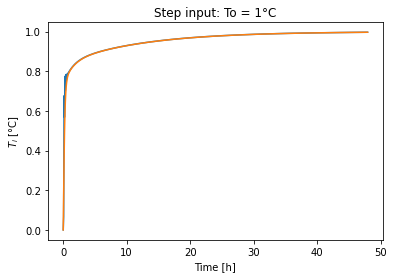

In [40]:
y_exp = Cs @ temp_exp + Ds @  u
y_imp = Cs @ temp_imp + Ds @  u

fig, ax = plt.subplots()
ax.plot(t / 3600, y_exp.T, t / 3600, y_imp.T)
ax.set(xlabel='Time [h]',
       ylabel='$T_i$ [°C]',
       title='Step input: To = 1°C')
plt.show()

In [41]:
b = np.zeros(12)
b[[0, 8, 10]] = 1
f = np.zeros(8)

ytc = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)
print('Steady-state indoor temperature obtained with:')
print(f'- DAE model: {ytc[6]:.4f} °C')
print(f'- response to step input:{float(y_exp[:, -2]):.4f} °C')

Steady-state indoor temperature obtained with:
- DAE model: 1.0000 °C
- response to step input:0.9969 °C


### Simulation with weather data

Read the hourly weather data file from start date to end date. The data are for a year (the choice of 2000 for the year is arbitrary).

In [42]:
filename = 'FRA_Lyon.074810_IWEC.epw'
start_date = '2000-01-03 12:00:00'
end_date = '2000-02-05 18:00:00'

# Read weather data from Energyplus .epw file
[data, meta] = dm4bem.read_epw(filename, coerce_year=None)
weather = data[["temp_air", "dir_n_rad", "dif_h_rad"]]
del data
weather.index = weather.index.map(lambda t: t.replace(year=2000))
weather = weather[(weather.index >= start_date) & (
    weather.index < end_date)]

From weather data, calculate the hourly solar radiation on a tilted surface, `Φt1` [W]:

In [43]:
surface_orientation = {'slope': 90,
                       'azimuth': 0,
                       'latitude': 45}
albedo = 0.2
rad_surf1 = dm4bem.sol_rad_tilt_surf(weather, surface_orientation, albedo)
rad_surf1['Φt1'] = rad_surf1.sum(axis=1)

The weather data is at the time-step of 1h. It needs to be at time step of `dt`. 

In [44]:
data = pd.concat([weather['temp_air'], rad_surf1['Φt1']], axis=1)
data = data.resample(str(dt) + 'S').interpolate(method='linear')
data = data.rename(columns={'temp_air': 'To'})

Let's consider the indoor temperature setpoint `Ti` and auxiliary heat flow `Qa` constant for the whole simulation period.

In [45]:
data['Ti'] = 20 * np.ones(data.shape[0])
data['Qa'] = 0 * np.ones(data.shape[0])

The simulation time vector, at time step `dt`is:

In [46]:
t = dt * np.arange(data.shape[0])

The input vector is formed by the temperature sources $\left [ T_o, T_o ,T_o, T_{i,sp} \right ]$ and the heat flow sources $\left [ \Phi_o, \Phi_i, \dot{Q_a}, \Phi_a \right ]$

In [47]:
u = pd.concat([data['To'], data['To'], data['To'], data['Ti'],
               α_wSW * wall['Surface']['Concrete'] * data['Φt1'],
               τ_gSW * α_wSW * wall['Surface']['Glass'] * data['Φt1'],
               data['Qa'],
               α_gSW * wall['Surface']['Glass'] * data['Φt1']], axis=1)

The initial value of the state-vector can be different of zero:

In [48]:
temp_exp = 20 * np.ones([As.shape[0], u.shape[0]])

Explicit Euler integration in time
$$ \theta_{k+1} = (I + \Delta t A) \theta _k + \Delta t B u_k $$

In [49]:
for k in range(u.shape[0] - 1):
    temp_exp[:, k + 1] = (I + dt * As) @ temp_exp[:, k]\
        + dt * Bs @ u.iloc[k, :]

yields the time variation of state variable $\theta$, from which we obtain the variation of the output (i.e. indoor temperature):
$$y = C_s \theta + D_s u$$
and the variation of the heat flow of the HVAC system:
$$q_{HVAC} = K_p (T_{i,sp} - y)$$
where $K_p$ is the gain of the P-controller and $T_{i,sp}$ is the HVAC-setpoint for the indoor temperature.

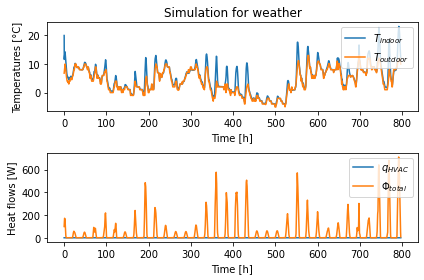

In [50]:
y_exp = Cs @ temp_exp + Ds @ u.to_numpy().T
q_HVAC = Kp * (data['Ti'] - y_exp[0, :])

fig, axs = plt.subplots(2, 1)
# plot indoor and outdoor temperature
axs[0].plot(t / 3600, y_exp[0, :], label='$T_{indoor}$')
axs[0].plot(t / 3600, data['To'], label='$T_{outdoor}$')
axs[0].set(xlabel='Time [h]',
           ylabel='Temperatures [°C]',
           title='Simulation for weather')
axs[0].legend(loc='upper right')

# plot total solar radiation and HVAC heat flow
axs[1].plot(t / 3600,  q_HVAC, label='$q_{HVAC}$')
axs[1].plot(t / 3600, data['Φt1'], label='$Φ_{total}$')
axs[1].set(xlabel='Time [h]',
           ylabel='Heat flows [W]')
axs[1].legend(loc='upper right')

fig.tight_layout()

## Discussion

The time step depends on:

- P-controller gain `Kp`:
    - if $K_p \rightarrow \infty$, then the controller is perfect and the time step needs to be small;
    - if $K_p \rightarrow 0$, then,the controller is inefffective and the building is in free-running.
- Capacities considered into the model:
    - if the capacities of the air $C_a =$ `C['Air']` and $C_g =$ `C['Glass']`are considered, then the time step is small;
    - if the capacities of the air and of the glas are zero, then the time step is large.

The controller models an HVAC system capable to heat (when $q_{HVAC} > 0$) and to cool $q_{HVAC} < 0$).

**References**

C. Ghiaus (2013) Causality issue in the heat balance method for calculating the design heating and cooling loads, *Energy* 50: 292-301, https://doi.org/10.1016/j.energy.2012.10.024

J.A. Duffie, W. A. Beckman, N. Blair (2020) Solar Engineering of Thermal Processes, 5th ed. John Wiley & Sons, Inc. ISBN 9781119540281

CSTB (2005) Réglementation Thermique 2005. Méthode de calcul Th-CE. Annexe à l’arrêté du 19 juillet 2006